# Imports

In [1]:
import numpy as np
import os
import sys
import pickle
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable

## Helper Functions

In [2]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)

import fixedDensity as fd

# Set Directory Paths

In [3]:
# Directory path to load formatted Layer Data
%store -r layer_dataDir

# Directory path to save Calcualted Analysis Data
%store -r layer_CalData

# Directory path to save Figures
%store -r layer_Fig

# Loading

## HC

In [4]:
# SMI32_HC
with open(os.path.join(layer_dataDir, 'SMI32_HC.pkl'), 'rb') as f:
    SMI32_HC = pickle.load(f)
f.close()

# SMI32_HC_w
with open(os.path.join(layer_dataDir, 'SMI32_HC_w.pkl'), 'rb') as f:
    SMI32_HC_w = pickle.load(f)
f.close()

In [5]:
SMI32_HC.shape

(32, 10)

## Tau

In [6]:
# SMI32_Tau
with open(os.path.join(layer_dataDir, 'SMI32_Tau.pkl'), 'rb') as f:
    SMI32_Tau = pickle.load(f)
f.close()

# SMI32_Tau_w
with open(os.path.join(layer_dataDir, 'SMI32_Tau_w.pkl'), 'rb') as f:
    SMI32_Tau_w = pickle.load(f)
f.close()

In [7]:
SMI32_Tau.shape

(28, 10)

## TDP

In [8]:
# SMI32_TDP
with open(os.path.join(layer_dataDir, 'SMI32_TDP.pkl'), 'rb') as f:
    SMI32_TDP = pickle.load(f)
f.close()

# SMI32_TDP_w
with open(os.path.join(layer_dataDir, 'SMI32_TDP_w.pkl'), 'rb') as f:
    SMI32_TDP_w = pickle.load(f)
f.close()

In [9]:
SMI32_TDP.shape

(50, 10)

## Loading Covariance Matrices

In [10]:
# cov_SMI32_dict
with open(os.path.join(layer_CalData, 'cov_SMI32_dict.pkl'), 'rb') as f:
    cov_SMI32_dict = pickle.load(f)
f.close()

# cov_SMI32_dict_w
with open(os.path.join(layer_CalData, 'cov_SMI32_dict_w.pkl'), 'rb') as f:
    cov_SMI32_dict_w = pickle.load(f)
f.close()

## Loading Layer Neuron Labels (NeuN)

In [11]:
# SMI32_Labels
with open(os.path.join(layer_dataDir, 'SMI32_Labels.pkl'), 'rb') as f:
    SMI32_Labels = pickle.load(f)
f.close()

# Draw Graph Networks (NeuN)

## Define Variables

### Set fixed density value 

In [12]:
fd_val = 40

### Define Vectors for Node Size and Node Color

In [13]:
# Variable setting
neuron_type = "SMI32"

HC_data = SMI32_HC
Tau_Data = SMI32_Tau
TDP_Data = SMI32_TDP

cov_dict = cov_SMI32_dict

data_label = SMI32_Labels

In [14]:
HC_data_exp = HC_data
Tau_Data_exp = Tau_Data
TDP_DataP_exp = TDP_Data

# Get min/max value of layers
minLayer = np.nanmin(np.vstack([HC_data_exp, Tau_Data_exp, TDP_DataP_exp]), axis=0)
maxLayer = np.nanmax(np.vstack([HC_data_exp, Tau_Data_exp, TDP_DataP_exp]), axis=0)

# Size of Nodes --> Marker
markerVecHC = np.nanmean(HC_data_exp, axis=0)
markerVecHC = 1000 * (markerVecHC - minLayer) / maxLayer

markerVecTau = np.nanmean(Tau_Data_exp, axis=0)
markerVecTau = 3 * (markerVecTau - minLayer) / maxLayer

markerVecTDP = np.nanmean(TDP_DataP_exp, axis=0)
markerVecTDP = 3 * (markerVecTDP - minLayer) / maxLayer

# Node color --> Set as red (because cm.jet: 1 --> Red)
colorVecHC = np.ones(HC_data_exp.shape[1])
colorVecTau = np.ones(Tau_Data_exp.shape[1])
colorVecTDP = np.ones(TDP_DataP_exp.shape[1])

## Generate Dict for Node Name Assignment

In [15]:
labels_dict = {}

node_num = 0

for label in data_label:
    labels_dict[node_num] = label
    node_num += 1

print(labels_dict)

{0: 'ln_L23_1', 1: 'ln_L23_2', 2: 'ln_L23_3', 3: 'ln_L23_4', 4: 'ln_L23_5', 5: 'ln_L56_1', 6: 'ln_L56_2', 7: 'ln_L56_3', 8: 'ln_L56_4', 9: 'ln_L56_5'}


## Visualization Helper Function

In [41]:
def layerGraphViz(covMat, label_dict, fig_name, edgecolor=True, edgeannot=False, figsave=False):

    # Define figure
    fig = plt.figure()

    # Substitute NaN values in covMat to 0
    covMat[np.isnan(covMat)] = 0

    # Get upper triangle of covMat
    covMat = np.triu(covMat)

    # Get graph of covMat
    G = nx.Graph(covMat)

    #### NODES ####
    # Assign node names
    nx.set_node_attributes(G, label_dict, 'name')
    labels = nx.get_node_attributes(G, 'name')

    # Assign Node positions
    pos = {0: (-2, 0),  # L23_1
           1: (-2, 1),  # L23_2
           2: (-2, 2),  # L23_3
           3: (-1.5, -2), # L23_4
           4: (2, 1.5),   # L23_5
           5: (-1, 0),  # L56_1
           6: (-1, 1),  # L56_2
           7: (-1, 2),  # L56_3
           8: (-0.5, -2), # L56_4
           9: (1, 1.5)}   # L56_5

    #### EDGES ####
    if edgecolor:
        # Calculate edge weights based on covariance matrix
        edge_weights = [G[i][j]['weight'] for i, j in G.edges()]

        edge_color_map = plt.cm.ScalarMappable(cmap=plt.cm.jet)
        edge_color_map.set_array(edge_weights)
        
        if edgeannot: 
            # Add edge labels
            edge_labels = nx.get_edge_attributes(G, 'weight')
            
            rounded_dict = {key: round(value, 2) for key, value in edge_labels.items()}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=rounded_dict, font_color='red')

        #### DRAW THE GRAPH ####
        nx.draw_networkx(G, pos, with_labels=True, labels=labels, font_weight='bold', 
                         edge_color=edge_weights, cmap=plt.cm.jet)
        
        # Add colorbar using the mappable object
        cbar = plt.colorbar(edge_color_map)
        
    else:
        #### DRAW THE GRAPH ####
        nx.draw_networkx(G, pos, with_labels=True, labels=labels, font_weight='bold')
    
    # Add a title to the figure
    plt.title(fig_name)
    
    # Save figure
    if figsave:
        # Save the plot as an image file (e.g., PNG)
        plt.savefig(layer_Fig + '/' + fig_name + '.png', format='png')
    
    # Display figure
    plt.show()

## HC

/Users/hyroh/anaconda3/envs/Network_Analysis/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:462: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/var/folders/d_/hlp96bh14c98xy43dzm6gp6c0000gn/T/ipykernel_72749/3941846707.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(edge_color_map)


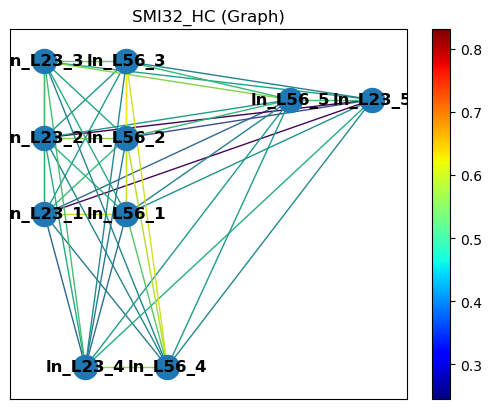

In [17]:
layerGraphViz(cov_dict['HC'], labels_dict, fig_name = neuron_type + '_HC (Graph)', edgecolor=True, edgeannot=False, figsave=True)

In [43]:
pd.DataFrame(cov_dict['HC'])

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.741037,0.575338,0.372747,0.198406,0.767905,0.648386,0.538757,0.413241,0.379665
1,0.741037,0.000000,0.656805,0.603965,0.234162,0.604908,0.704830,0.529225,0.492120,0.547320
2,0.575338,0.656805,0.000000,0.599651,0.492461,0.590500,0.590984,0.686273,0.445412,0.656894
3,0.372747,0.603965,0.599651,0.000000,0.528555,0.432929,0.505882,0.482461,0.723652,0.494332
4,0.198406,0.234162,0.492461,0.528555,0.000000,0.557480,0.404333,0.448114,0.411188,0.635503
5,0.767905,0.604908,0.590500,0.432929,0.557480,0.000000,0.838737,0.756938,0.617706,0.476349
6,0.648386,0.704830,0.590984,0.505882,0.404333,0.838737,0.000000,0.812460,0.741961,0.620343
7,0.538757,0.529225,0.686273,0.482461,0.448114,0.756938,0.812460,0.000000,0.760334,0.597990
8,0.413241,0.492120,0.445412,0.723652,0.411188,0.617706,0.741961,0.760334,0.000000,0.470002
9,0.379665,0.547320,0.656894,0.494332,0.635503,0.476349,0.620343,0.597990,0.470002,0.000000


/var/folders/d_/hlp96bh14c98xy43dzm6gp6c0000gn/T/ipykernel_72749/536329232.py:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(edge_color_map)


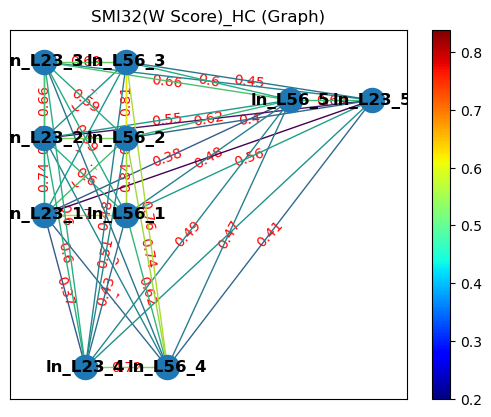

In [42]:
layerGraphViz(cov_dict['HC'], labels_dict, fig_name = neuron_type + '_HC (Graph)', edgecolor=True, edgeannot=True, figsave=True)

## Tau

/var/folders/d_/hlp96bh14c98xy43dzm6gp6c0000gn/T/ipykernel_72749/3941846707.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(edge_color_map)


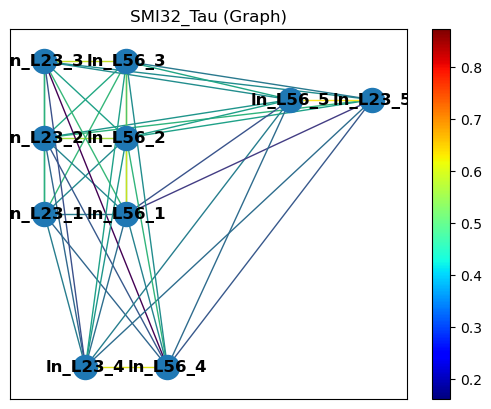

In [18]:
layerGraphViz(cov_dict['TAU'], labels_dict, fig_name = neuron_type + '_Tau (Graph)', edgecolor=True, edgeannot=False, figsave=True)

/Users/hyroh/anaconda3/envs/Network_Analysis/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:462: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/var/folders/d_/hlp96bh14c98xy43dzm6gp6c0000gn/T/ipykernel_72749/536329232.py:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(edge_color_map)


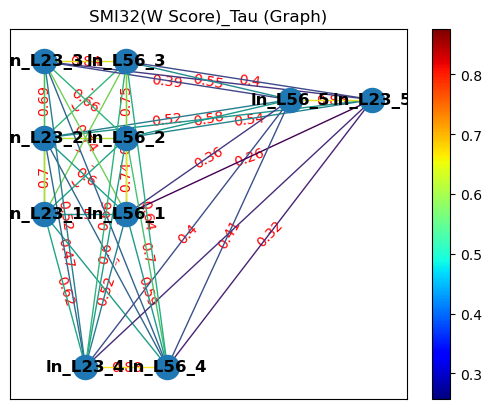

In [44]:
layerGraphViz(cov_dict['TAU'], labels_dict, fig_name = neuron_type + '_Tau (Graph)', edgecolor=True, edgeannot=True, figsave=True)

## TDP

/var/folders/d_/hlp96bh14c98xy43dzm6gp6c0000gn/T/ipykernel_72749/3941846707.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(edge_color_map)


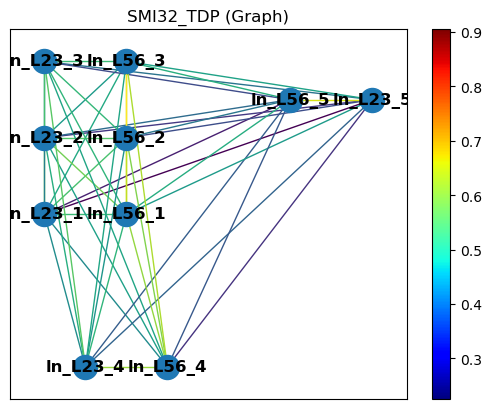

In [19]:
layerGraphViz(cov_dict['TDP'], labels_dict, fig_name = neuron_type + '_TDP (Graph)', edgecolor=True, edgeannot=False, figsave=True)

## HC > Tau

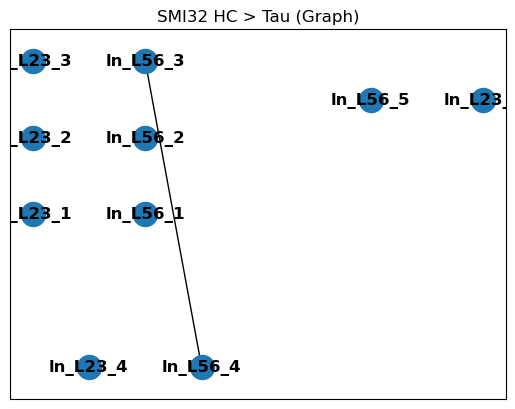

In [20]:
layerGraphViz(cov_dict['TAU_lt_HC'], labels_dict, fig_name = neuron_type + ' HC > Tau (Graph)', edgecolor=False, edgeannot=False, figsave=True)

## Tau > HC

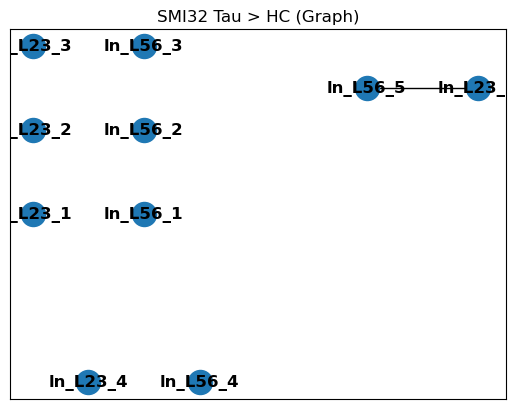

In [21]:
layerGraphViz(cov_dict['TAU_gt_HC'], labels_dict, fig_name = neuron_type + ' Tau > HC (Graph)', edgecolor=False, edgeannot=False, figsave=True)

## HC > TDP

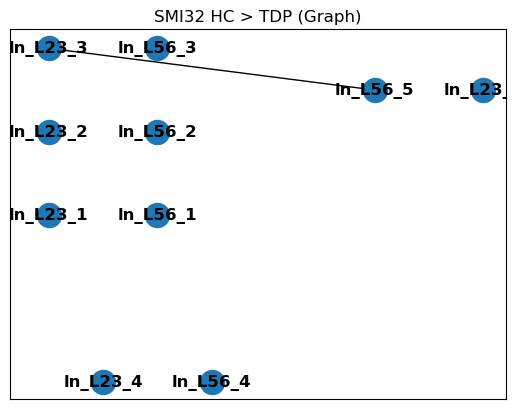

In [22]:
layerGraphViz(cov_dict['TDP_lt_HC'], labels_dict, fig_name = neuron_type + ' HC > TDP (Graph)', edgecolor=False, edgeannot=False, figsave=True)

## TDP > HC

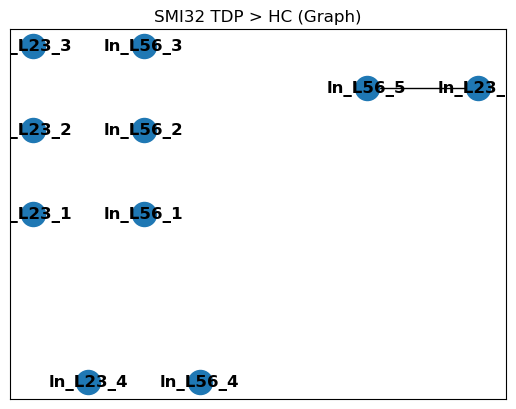

In [23]:
layerGraphViz(cov_dict['TDP_gt_HC'], labels_dict, fig_name = neuron_type +' TDP > HC (Graph)', edgecolor=False, edgeannot=False, figsave=True)

## Tau > TDP

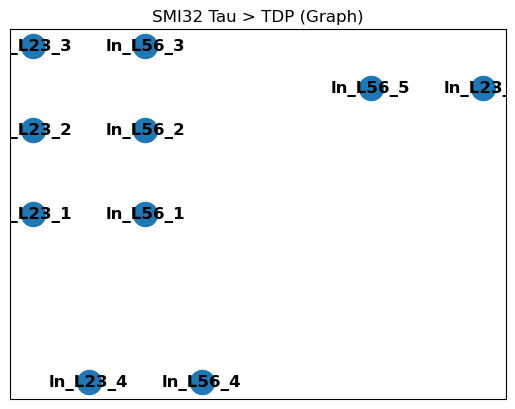

In [24]:
layerGraphViz(cov_dict['TAU_gt_TDP'], labels_dict, fig_name = neuron_type +' Tau > TDP (Graph)', edgecolor=False, edgeannot=False, figsave=True)

## TDP > Tau

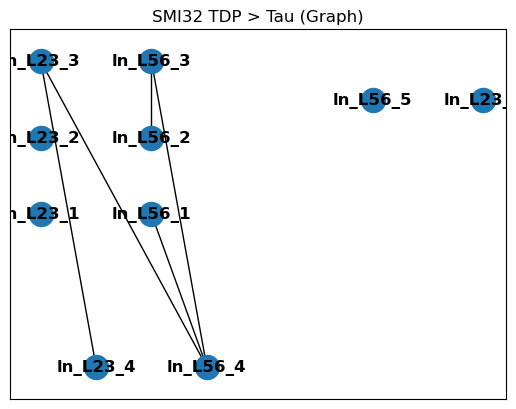

In [25]:
layerGraphViz(cov_dict['TDP_gt_TAU'], labels_dict, fig_name = neuron_type +' TDP > Tau (Graph)', edgecolor=False, edgeannot=False, figsave=True)

# Draw Graph Networks (NeuN) W Score

### Define Vectors for Node Size and Node Color

In [26]:
# Variable setting
neuron_type = "SMI32(W Score)"

HC_data = SMI32_HC_w
Tau_Data = SMI32_Tau_w
TDP_Data = SMI32_TDP_w

cov_dict = cov_SMI32_dict_w

data_label = SMI32_Labels

In [27]:
HC_data_exp = HC_data
Tau_Data_exp = Tau_Data
TDP_DataP_exp = TDP_Data

# Get min/max value of layers
minLayer = np.nanmin(np.vstack([HC_data_exp, Tau_Data_exp, TDP_DataP_exp]), axis=0)
maxLayer = np.nanmax(np.vstack([HC_data_exp, Tau_Data_exp, TDP_DataP_exp]), axis=0)

# Size of Nodes --> Marker
markerVecHC = np.nanmean(HC_data_exp, axis=0)
markerVecHC = 1000 * (markerVecHC - minLayer) / maxLayer

markerVecTau = np.nanmean(Tau_Data_exp, axis=0)
markerVecTau = 3 * (markerVecTau - minLayer) / maxLayer

markerVecTDP = np.nanmean(TDP_DataP_exp, axis=0)
markerVecTDP = 3 * (markerVecTDP - minLayer) / maxLayer

# Node color --> Set as red (because cm.jet: 1 --> Red)
colorVecHC = np.ones(HC_data_exp.shape[1])
colorVecTau = np.ones(Tau_Data_exp.shape[1])
colorVecTDP = np.ones(TDP_DataP_exp.shape[1])

## Generate Dict for Node Name Assignment

In [28]:
labels_dict = {}

node_num = 0

for label in data_label:
    labels_dict[node_num] = label
    node_num += 1

print(labels_dict)

{0: 'ln_L23_1', 1: 'ln_L23_2', 2: 'ln_L23_3', 3: 'ln_L23_4', 4: 'ln_L23_5', 5: 'ln_L56_1', 6: 'ln_L56_2', 7: 'ln_L56_3', 8: 'ln_L56_4', 9: 'ln_L56_5'}


## HC

/var/folders/d_/hlp96bh14c98xy43dzm6gp6c0000gn/T/ipykernel_72749/3941846707.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(edge_color_map)


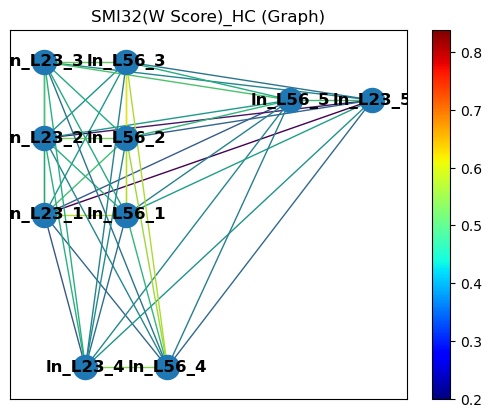

In [29]:
layerGraphViz(cov_dict['HC'], labels_dict, fig_name = neuron_type + '_HC (Graph)', edgecolor=True, edgeannot=False, figsave=True)

## Tau

/var/folders/d_/hlp96bh14c98xy43dzm6gp6c0000gn/T/ipykernel_72749/3941846707.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(edge_color_map)


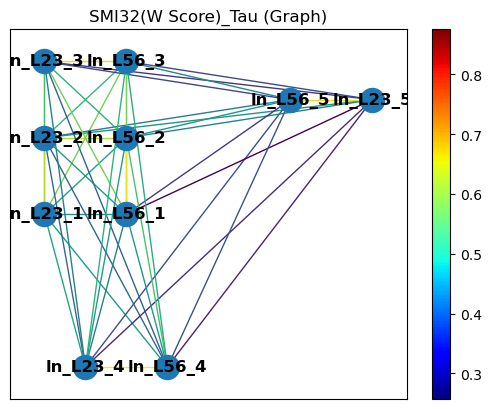

In [30]:
layerGraphViz(cov_dict['TAU'], labels_dict, fig_name = neuron_type + '_Tau (Graph)', edgecolor=True, edgeannot=False, figsave=True)

## TDP

/var/folders/d_/hlp96bh14c98xy43dzm6gp6c0000gn/T/ipykernel_72749/3941846707.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(edge_color_map)


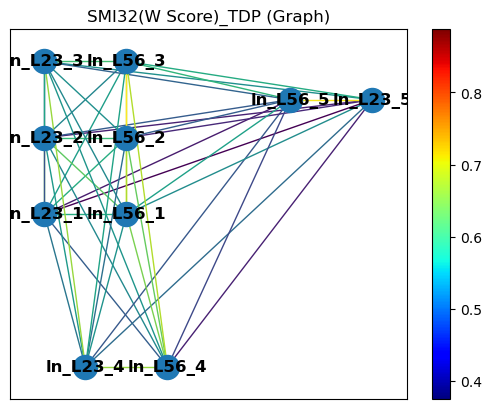

In [31]:
layerGraphViz(cov_dict['TDP'], labels_dict, fig_name = neuron_type + '_TDP (Graph)', edgecolor=True, edgeannot=False, figsave=True)

## HC > Tau

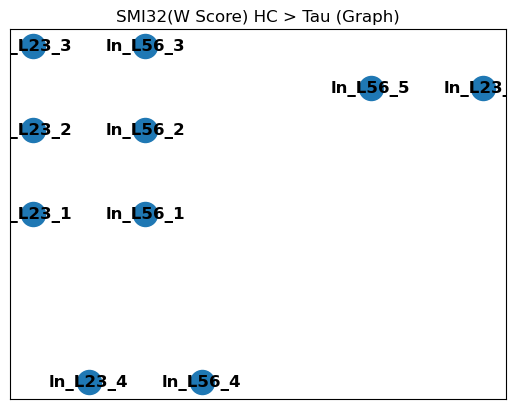

In [32]:
layerGraphViz(cov_dict['TAU_lt_HC'], labels_dict, fig_name = neuron_type + ' HC > Tau (Graph)', edgecolor=False, edgeannot=False, figsave=True)

## Tau > HC

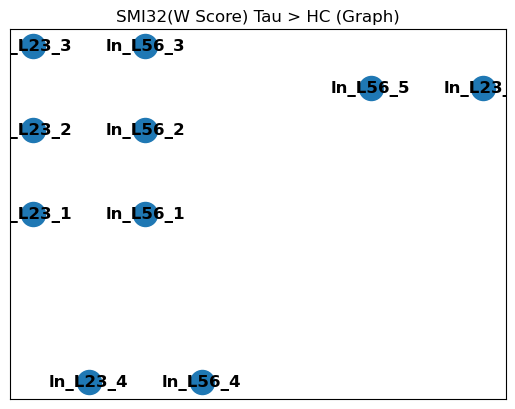

In [33]:
layerGraphViz(cov_dict['TAU_gt_HC'], labels_dict, fig_name = neuron_type + ' Tau > HC (Graph)', edgecolor=False, edgeannot=False, figsave=True)

## HC > TDP

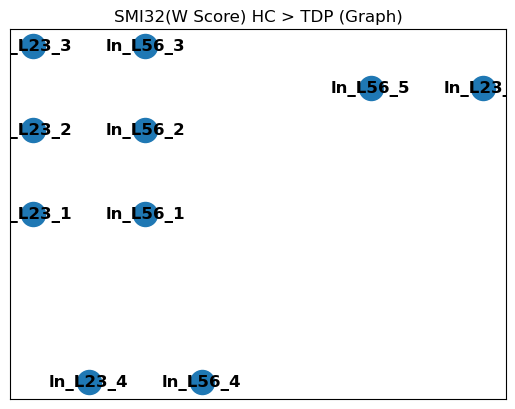

In [34]:
layerGraphViz(cov_dict['TDP_lt_HC'], labels_dict, fig_name = neuron_type + ' HC > TDP (Graph)', edgecolor=False, edgeannot=False, figsave=True)

## TDP > HC

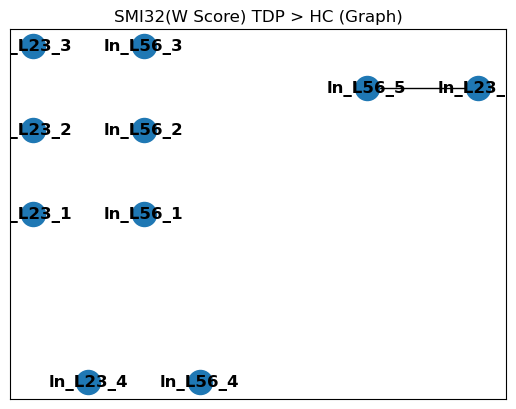

In [35]:
layerGraphViz(cov_dict['TDP_gt_HC'], labels_dict, fig_name = neuron_type +' TDP > HC (Graph)', edgecolor=False, edgeannot=False, figsave=True)

## Tau > TDP

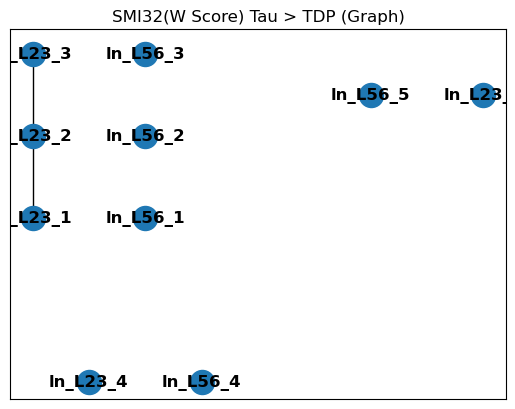

In [36]:
layerGraphViz(cov_dict['TAU_gt_TDP'], labels_dict, fig_name = neuron_type +' Tau > TDP (Graph)', edgecolor=False, edgeannot=False, figsave=True)

## TDP > Tau

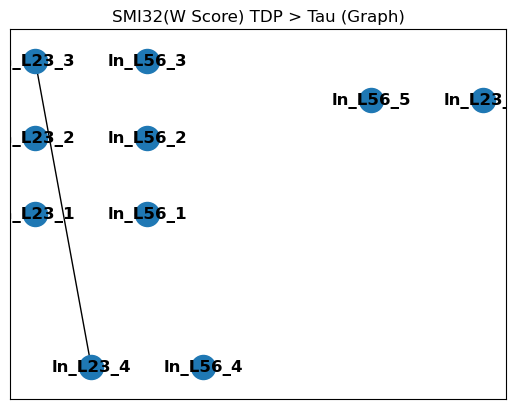

In [37]:
layerGraphViz(cov_dict['TDP_gt_TAU'], labels_dict, fig_name = neuron_type +' TDP > Tau (Graph)', edgecolor=False, edgeannot=False, figsave=True)